## [HUFS NLP] 자연어 처리 이론 및 실습 # 2 : Text preprocessing & representation
* Word2bVec
* GloVe
* FastText

예상 난이도 ⭐️

## 실습 요약
* 분상표상 기반의 임베딩 기법을 학습합니다
* 여러가지 임베딩 기법을 통해 간단한 모델을 구축한 후 성능을 비교합니다

------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [1]:
! pip install konlpy -q
! pip install glove-python3 -q

In [2]:
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[2.1.0+cu121].
device:[cpu].


In [3]:
# set random seed

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

random_seed = 2024
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)




In [4]:
# 데이터셋 읽기
with open('./naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()

In [5]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive,
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(1) # positive
  else:
    label.append(-1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 361655.87it/s]


In [6]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=2024)

<Axes: >

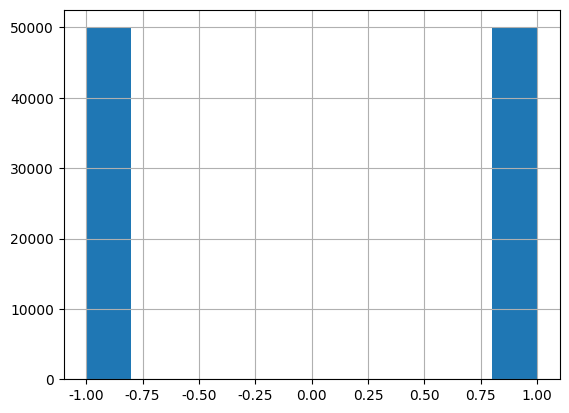

In [7]:
df['label'].hist()

In [8]:
df.head()

,rate,label,sentence
17285,4,1,커플로 쓰려고 구매했습니다:) 여자에게는 사이즈가 맞는데 남자한테는 살짝 작네요 음...
103773,2,-1,물에다았을때 지속력이떨어져요
13313,2,-1,많이 실망햇어요.. 앞으로 식품은 안시켜먹을듯
151444,5,1,방수에 쓰기 좋아요
10193,5,1,여름이라 피부가 많이 타서 기존피어싱이 잘 안어울렸는데 네온컬러 예뻐요!!💚🧡운동때...


### STEP 2. 데이터 전처리 (Preprocessing)

In [9]:
review_sentences = df['sentence'].to_list()

In [10]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
  text = re.sub('[ㅠㅎㅋ]','', text)
  return text

In [11]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 218736.10it/s]


In [12]:
df

,rate,label,sentence,normalize_sentence
17285,4,1,커플로 쓰려고 구매했습니다:) 여자에게는 사이즈가 맞는데 남자한테는 살짝 작네요 음...,커플로 쓰려고 구매했습니다 여자에게는 사이즈가 맞는데 남자한테는 살짝 작네요 음.....
103773,2,-1,물에다았을때 지속력이떨어져요,물에다았을때 지속력이떨어져요
13313,2,-1,많이 실망햇어요.. 앞으로 식품은 안시켜먹을듯,많이 실망햇어요.. 앞으로 식품은 안시켜먹을듯
151444,5,1,방수에 쓰기 좋아요,방수에 쓰기 좋아요
10193,5,1,여름이라 피부가 많이 타서 기존피어싱이 잘 안어울렸는데 네온컬러 예뻐요!!💚🧡운동때...,여름이라 피부가 많이 타서 기존피어싱이 잘 안어울렸는데 네온컬러 예뻐요💚🧡운동때문에...
...,...,...,...,...
85134,2,-1,겉은멀쩡한데 속은 상한게 많아요 실망입니다,겉은멀쩡한데 속은 상한게 많아요 실망입니다
185929,2,-1,냄새가 너무 많이나고 접시가 자꾸 달라붙어서 덜 실용적이네요.,냄새가 너무 많이나고 접시가 자꾸 달라붙어서 덜 실용적이네요.
187481,4,1,잘 먹고 있습니다. 효과라기 보다는 필수로 .....,잘 먹고 있습니다. 효과라기 보다는 필수로 .....
136365,2,-1,음... 호환은 되는데 꼭지가 입구부분이ㅡ좀 나팔처럼 생기고 우선 애기가 먹다가 입...,음... 호환은 되는데 꼭지가 입구부분이ㅡ좀 나팔처럼 생기고 우선 애기가 먹다가 입...


### STEP 3. 토큰화 진행 (Tokenization)

In [13]:
# Okt(Open Korea Text)
from konlpy.tag import Okt
okt=Okt()

okt.morphs(normalize_sentence[0])

['커플',
 '로',
 '쓰려고',
 '구매',
 '했습니다',
 '여자',
 '에게는',
 '사이즈',
 '가',
 '맞는데',
 '남자',
 '한테',
 '는',
 '살짝',
 '작네요',
 '음',
 '..',
 '상품',
 '문제',
 '는',
 '아닌',
 '것',
 '같지만',
 '후기',
 '를',
 '솔직히',
 '남겨',
 '봅니다',
 '..']

In [14]:
tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = okt.morphs(sent)
  tokenized_sentence.append(sent)

100%|██████████| 100000/100000 [05:29<00:00, 303.82it/s]


In [15]:
df['tokenized_sentence'] = tokenized_sentence

In [16]:
df.head()

,rate,label,sentence,normalize_sentence,tokenized_sentence
17285,4,1,커플로 쓰려고 구매했습니다:) 여자에게는 사이즈가 맞는데 남자한테는 살짝 작네요 음...,커플로 쓰려고 구매했습니다 여자에게는 사이즈가 맞는데 남자한테는 살짝 작네요 음.....,"[커플, 로, 쓰려고, 구매, 했습니다, 여자, 에게는, 사이즈, 가, 맞는데, 남..."
103773,2,-1,물에다았을때 지속력이떨어져요,물에다았을때 지속력이떨어져요,"[물, 에다, 았, 을, 때, 지속, 력, 이, 떨어져요]"
13313,2,-1,많이 실망햇어요.. 앞으로 식품은 안시켜먹을듯,많이 실망햇어요.. 앞으로 식품은 안시켜먹을듯,"[많이, 실망, 햇, 어, 요, .., 앞, 으로, 식품, 은, 안, 시켜, 먹을듯]"
151444,5,1,방수에 쓰기 좋아요,방수에 쓰기 좋아요,"[방수, 에, 쓰기, 좋아요]"
10193,5,1,여름이라 피부가 많이 타서 기존피어싱이 잘 안어울렸는데 네온컬러 예뻐요!!💚🧡운동때...,여름이라 피부가 많이 타서 기존피어싱이 잘 안어울렸는데 네온컬러 예뻐요💚🧡운동때문에...,"[여름, 이라, 피부, 가, 많이, 타서, 기존, 피어싱, 이, 잘, 안, 어울렸는..."


<Axes: >

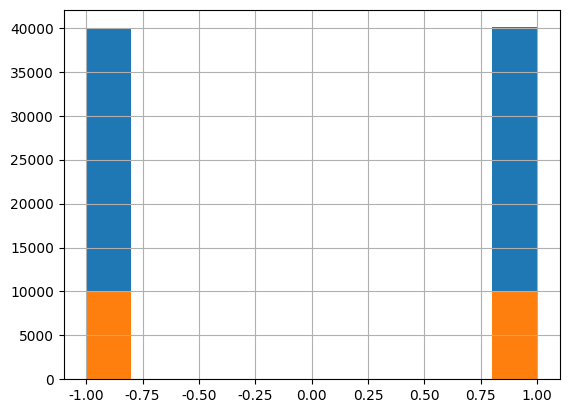

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
train_df['label'].hist()
test_df['label'].hist()

### STEP 4. 벡터화 진행 (Vectorization)

#### Method 1. Word2Vec

In [18]:
from gensim.models import Word2Vec

In [19]:
train_sentence = train_df['tokenized_sentence'].to_list()
test_sentence = test_df['tokenized_sentence'].to_list()

In [20]:
%%time

model = Word2Vec(
    sentences=train_sentence,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    seed=random_seed)

CPU times: user 13.8 s, sys: 155 ms, total: 13.9 s
Wall time: 7.94 s


In [21]:
model.build_vocab([['<UNK>']],update=True)

In [ ]:
# model.save("word2vec.model")

In [23]:
vocab = list(model.wv.index_to_key)

In [24]:
len(vocab),type(vocab)

(67928, list)

In [25]:
model.wv.most_similar('별로', topn=10)

[('별루', 0.8336011171340942),
 ('퀴드', 0.7080435156822205),
 ('골라내는게', 0.7006584405899048),
 ('반창고', 0.7004861235618591),
 ('헷갈려요', 0.6861124634742737),
 ('☹', 0.675281286239624),
 ('산듯쵝오', 0.6712638735771179),
 ('날렸네', 0.6689013242721558),
 ('그대로', 0.6648790836334229),
 ('싸구려', 0.6608191132545471)]

In [26]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [00:54<00:00, 365.94it/s]


In [27]:
train_df['w2v_sentence_vector'] = train_sentence_vector
test_df['w2v_sentence_vector'] = test_sentence_vector

#### Method 2. Glove

In [29]:
from glove import Corpus, Glove

corpus = Corpus()

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(train_sentence, window=5)
glove = Glove(no_components=100, learning_rate=0.05, random_state=2024)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [30]:
glove.most_similar("별로",number=10)

[('에요', 0.9366742949305389),
 ('예요', 0.9133617389333968),
 ('임', 0.8983923454640644),
 ('였어요', 0.8832939652662833),
 ('별루', 0.8694994807752617),
 ('였네요', 0.8482244003750629),
 ('붙지안음', 0.8212692045321469),
 ('솔직히', 0.7985152031764169),
 ('최고', 0.7861423934610727)]

In [31]:
vocab = []
for word, word_idx in tqdm(glove.dictionary.items()):
  vocab.append(word)

100%|██████████| 67927/67927 [00:00<00:00, 1837383.27it/s]


In [32]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += glove.word_vectors[glove.dictionary[word]]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += glove.word_vectors[glove.dictionary[word]]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [01:01<00:00, 324.42it/s]


In [33]:
train_df['glove_sentence_vector'] = train_sentence_vector
test_df['glove_sentence_vector'] = test_sentence_vector

#### Method 3. FastText

In [34]:
%%time
from gensim.models import FastText

model = FastText(
    sentences = tokenized_sentence,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4)

CPU times: user 33.5 s, sys: 357 ms, total: 33.9 s
Wall time: 21.6 s


In [35]:
vocab = list(model.wv.index_to_key)

In [36]:
len(vocab)

77116

In [37]:
model.wv.most_similar('별로', topn=10)

[('별로넷', 0.9901315569877625),
 ('별루', 0.8376007080078125),
 ('닥별루', 0.8289772272109985),
 ('별루없', 0.8220986127853394),
 ('좀별루', 0.8215789198875427),
 ('핏이별루', 0.8204891681671143),
 ('쨋든별루', 0.8193995952606201),
 ('별루별루', 0.8188643455505371),
 ('별루별루별루별루', 0.8143751621246338),
 ('별루다', 0.8108457922935486)]

In [38]:
train_sentence_vector = []
for cur_sent in tqdm(train_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  train_sentence_vector.append(vector)

test_sentence_vector = []
for cur_sent in tqdm(test_sentence):
  vector = np.zeros(100,)
  for word in cur_sent:
    if word in vocab:
      vector += model.wv[word]
  test_sentence_vector.append(vector)

100%|██████████| 20000/20000 [00:36<00:00, 549.96it/s]


In [39]:
train_df['ft_sentence_vector'] = train_sentence_vector
test_df['ft_sentence_vector'] = test_sentence_vector

In [ ]:
# train_df.to_csv('./train_df.csv')
# test_df.to_csv('./test_df.csv')

### STEP 5. 모델 구축하기 (Modeling)
* Word2Vec, Glove, FastText를 활용하여 감성분석 모델 만들기


#### Word2Vec을 사용하여 감성 분석하기

In [56]:
w2v_df = train_df[['label','w2v_sentence_vector']]

In [57]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=2024)

sent_vec = np.stack(w2v_df.w2v_sentence_vector,axis=0)
label_vec = np.array(w2v_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [58]:
w2v_df = test_df[['label','w2v_sentence_vector']]
sent_vec = np.stack(w2v_df.w2v_sentence_vector,axis=0)
label_vec = np.array(w2v_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.75765

In [51]:
glove_df = train_df[['label','glove_sentence_vector']]

In [52]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=2024)

sent_vec = np.stack(glove_df.glove_sentence_vector,axis=0)
label_vec = np.array(glove_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [53]:
glove_df = test_df[['label','glove_sentence_vector']]

sent_vec = np.stack(glove_df.glove_sentence_vector,axis=0)
label_vec = np.array(glove_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.71645

In [54]:
from sklearn.tree import DecisionTreeClassifier
ft_df = train_df[['label','ft_sentence_vector']]

model = DecisionTreeClassifier(random_state=2024)

sent_vec = np.stack(ft_df.ft_sentence_vector,axis=0)
label_vec = np.array(ft_df.label.to_list()).reshape(-1,)

model = model.fit(sent_vec, label_vec)
model.score(sent_vec, label_vec)

0.9995625

In [55]:
ft_df = test_df[['label','ft_sentence_vector']]

sent_vec = np.stack(ft_df.ft_sentence_vector,axis=0)
label_vec = np.array(ft_df.label.to_list()).reshape(-1,)
model.score(sent_vec, label_vec)

0.75315